# Seminar 4 - Significance Tests

## Weibull distribution

In [1]:
library("ggplot2")

In [2]:
f_weibull <- function(u, k, x) {
    (k / u) * 
    ((x / u) ^ (k - 1)) * 
    exp(-((x / u) ^ k))
}

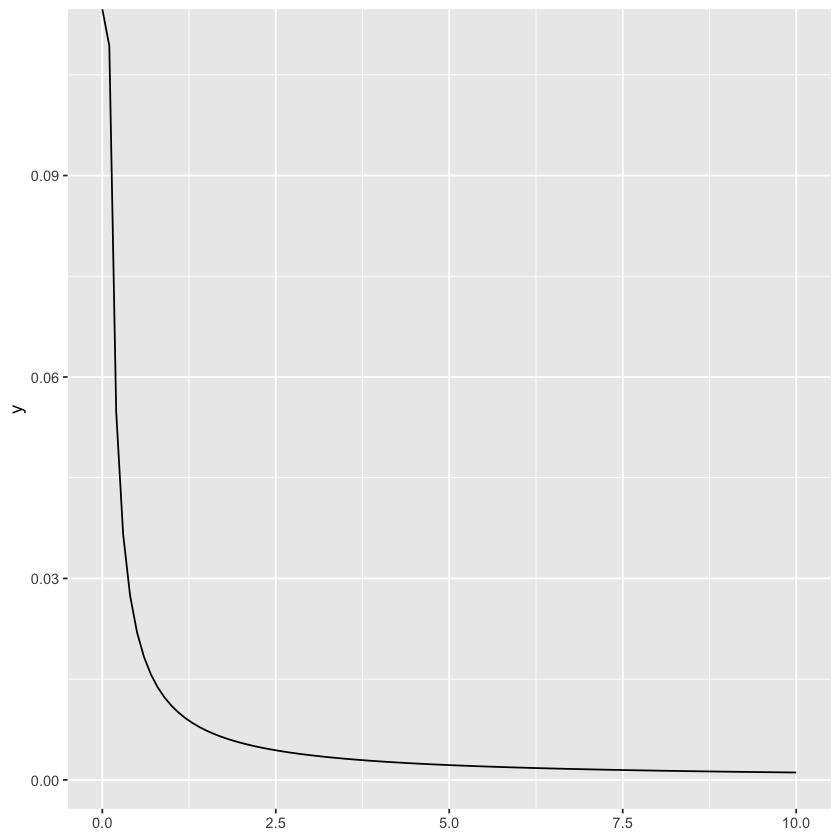

In [3]:
ggplot() + 
    xlim(0,10) + 
    geom_function(fun = function(x) f_weibull(u = 10, k = 0.03, x))

### Tasks
1. Show the correspondence of the exponential distribution and the Weibull distribution when the shape parameter k = 1.
2. Visualize the Weibull density function for the combinations of shape parameter k values in 0.25, 1 and 2 and scale parameter μ in 1 and 5 (six curves in total).

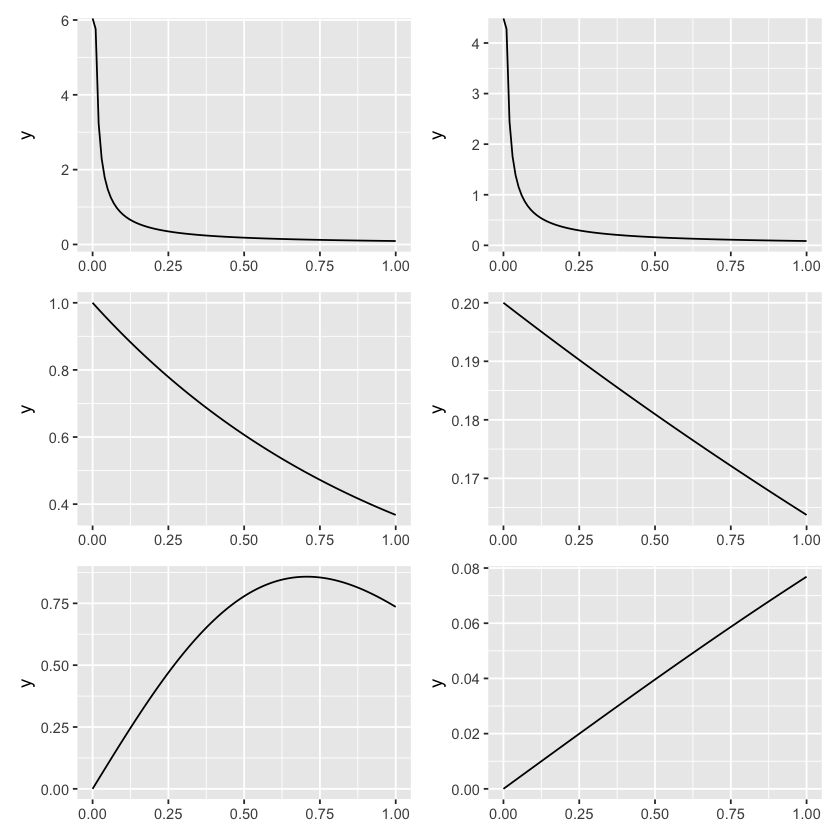

In [4]:
# An advanced way to get the six curves together with a legend is 
# to define a dataframe with all parameter combinations and to call geom_function repeatedly via purrr::pmap
library("purrr")
library("patchwork")

params <- data.frame(
    u = c(1, 1, 1, 5, 5, 5),
    k = c(0.25, 1, 2, 0.25, 1, 2)
)

# pmap(params, function(u, k) {
#     ggplot() + geom_function(fun = function(x) f_weibull(u, k, x))
# })

(ggplot() +
    geom_function(fun = f_weibull, args = list(u=1, k=0.25))) +
(ggplot() +
    geom_function(fun = f_weibull, args = list(u=5, k=0.25))) +
(ggplot() +
    geom_function(fun = f_weibull, args = list(u=1, k=1))) +
(ggplot() +
    geom_function(fun = f_weibull, args = list(u=5, k=1))) +
(ggplot() +
    geom_function(fun = f_weibull, args = list(u=1, k=2))) +
(ggplot() +
    geom_function(fun = f_weibull, args = list(u=5, k=2))) +
plot_layout(ncol = 2)

3. The cumulative distribution function (CDF) is an alternative view on the distribution as a whole. It describes how much probability mass lies below or equal to a specified value. Differentiating the CDF yields the probability density function (PDF). Can you deduce the cumulative distribution function for the Weibull distribution, i.e., what does the function FX:t↦P(X≤t) look when X is a random variable that follows a Weibull distribution?

In [393]:
cdf_weibull <- function(t, u, k) {
    integrate(function(x) f_weibull(u, k, x), 0, t)
}
cdf_weibull(t = 7, u = 8, k = 0.594)

0.6029712 with absolute error < 9.9e-06

## Survival Time after Brain tumour

In [6]:
surv_time <- readRDS("data/SPED_Seminar04_survtime_bt.rds")
surv_time

[1] 27.42  3.80  4.02  3.78  0.85  3.50 73.73 16.33  3.11  5.89  2.71  5.23
[13] 13.55  0.37 13.08  1.06 13.38 14.36 19.59 16.35 11.99 12.60 22.05 45.64
[25] 17.22  1.32  5.64  0.43  1.12 43.18  7.30 14.44 12.51  6.04 20.05  1.87
[37] 18.46 14.79  0.03  1.35  5.06  3.41 12.20  3.80 11.44  6.17  2.94  6.57
[49] 15.64  1.80 34.70 12.29  2.39  6.11 22.66  6.12  6.35  1.97 20.61  0.96
[61]  0.82 44.81 11.97 66.21 15.93  2.53 12.36  6.02 40.99  4.84 26.34  0.59

### Tasks - Maximum Likelihood
Imagine that — based on previous studies — you can safely assume that the survival time can be modelled by a Weibull distribution and that the scale parameter $μ$ of the Weibull distribution can be assumed to be $μ_0$ = 10.

1. What does the log-likelihood function look like for the shape parameter $k$ in this situation? Draw the curve.

Warning message in (x_samples/u0)^k:
“longer object length is not a multiple of shorter object length”


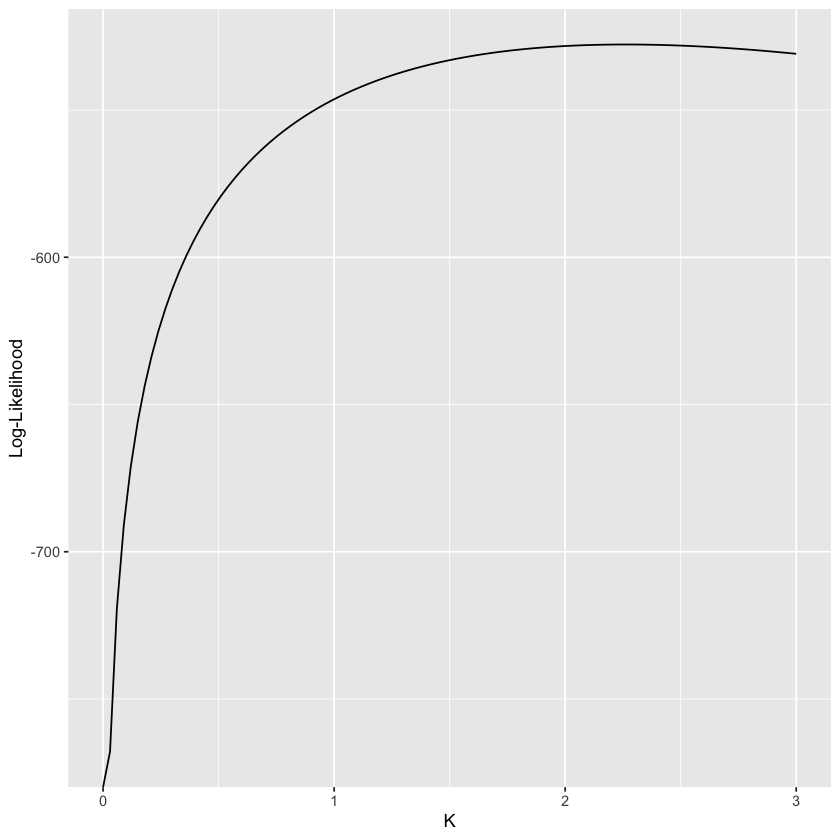

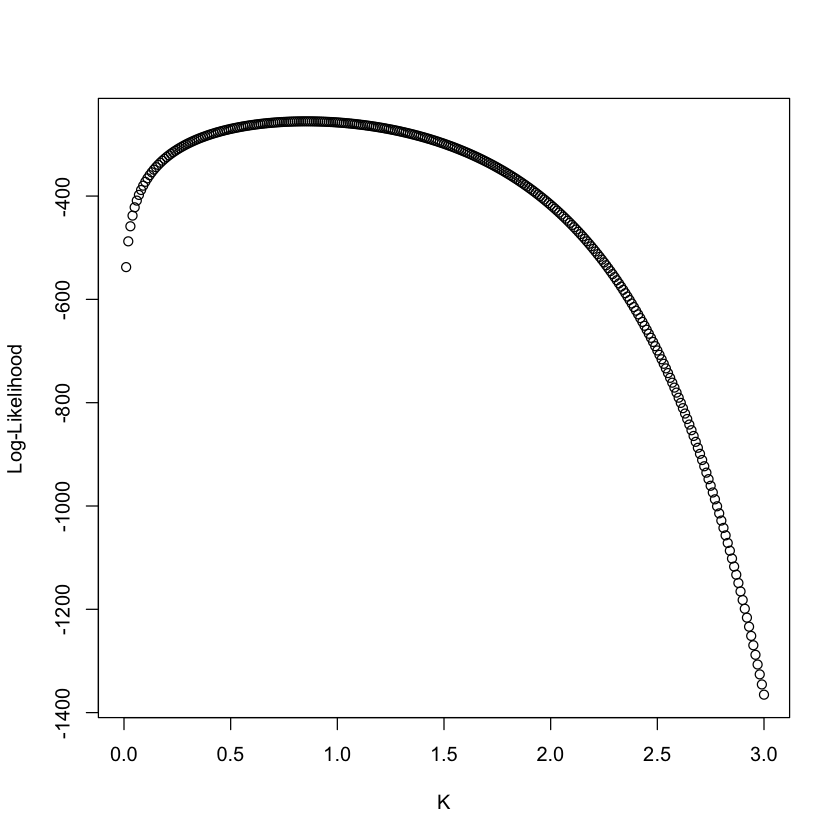

In [162]:
loglike_f_weibull <- function(k, x_samples, u0) {
    n <- length(x_samples)
    (n * log(k)) -
        (n * k * log(u0)) -
        sum( ((x_samples / u0) ^ k) ) +
        ( (k - 1) * sum(log(x_samples)) )
}

ggplot() +
    xlim(0.0,3.0) +
    geom_function(fun = loglike_f_weibull, args = list(x_samples = surv_time, u0 = 10)) +
    labs(x = "K", y = "Log-Likelihood")

# Naive
kl <- c(0:300)/100
ll <- c()
for (ki in kl) {
    ll <- c(ll, loglike_f_weibull(k = ki, x_samples = surv_time, u0 = 10))
}

plot(ll ~ kl, xlab = "K", ylab = "Log-Likelihood")

2. Use a numeric optimization routine to find the maximum likelihood estimate $k̂$.

In [325]:
optimize(loglike_f_weibull,
         interval = c(0.0, 3.0),
         maximum = TRUE,
         x_samples = surv_time, 
         u0 = 10)

$maximum
[1] 0.8537818

$objective
[1] -255.3204

### Tasks - Sampling distribution (Monte-Carlo simulation)
Consider as starting point the estimated Weibull-distribution from above, i.e. the Weibull distribution with scale parameter $μ=μ_0=10$ and shape parameter $k=k̂$. Now, take this distribution as known «ground truth» and take repeatedly (e.g. B=1001 times) random samples of varying sample sizes (n=3, 5, 10, 50, 100, 500, 1000) from this distribution. Based on each sample, estimate the shape parameter $k$ via MLE. The parameter estimates will vary from sample to sample and together it gives rise to the sampling distribution of the ML-estimator for $k$.

Show graphically the distribution of the estimate in the repeated sampling, for instance by means of a histogram, for each sample size $n$ separately. How would you describe its distribution. What can you say about its mean and variance depending on the sample size $n$?



In [378]:
k_max = 0.8537
n_samples = c(3, 5, 10, 50, 100, 500, 1000)

estimate_k_max <- function(n_size) {
    # Sample X from uniform and using X, sample from Weibull
    x <- runif(n_size, min = 0.0, max = 3.0)
    samples <- f_weibull(u = 10, k = k_max, x = x)

    # Find k_max_hat
    k_max_hat <- optimize(loglike_f_weibull, interval = c(0.0, 3.0),
         maximum = TRUE,
         x_samples = samples, 
         u0 = 10)

    k_max_hat$maximum
}

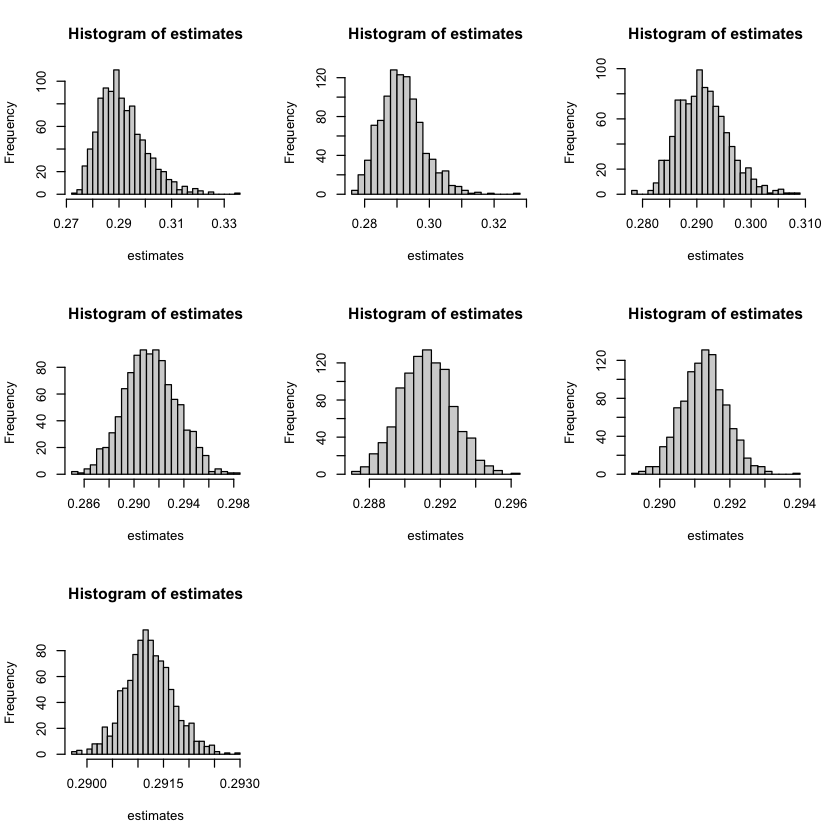

In [379]:
p <- par(mfrow=c(3,3))
k_max_mean <- c()
for (n in n_samples) {
    estimates <- c()
    # Estimate K^ 1001 times for N sample size
    for (i in c(0:1000)) {
        estimates <- c(estimates, estimate_k_max(n))
    }
    # Make a histogram
    hist(estimates, breaks = 25)
    k_max_mean <- c(k_max_mean, mean(estimates))
}
par(p)

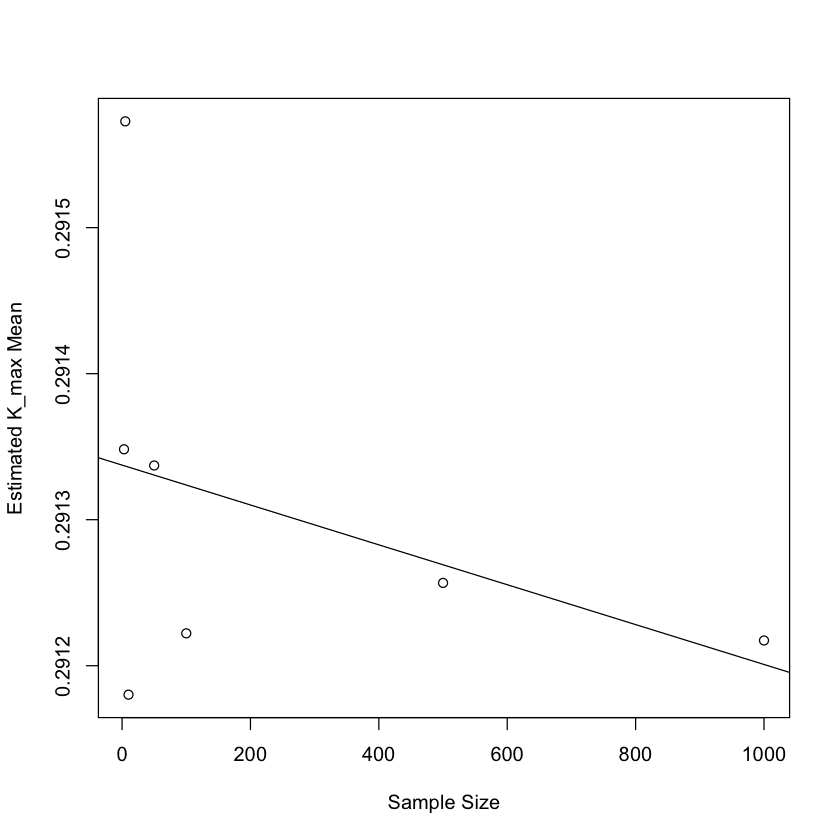

In [384]:
plot(k_max_mean ~ n_samples, xlab = "Sample Size", ylab = "Estimated K_max Mean")
abline(lm(k_max_mean ~ n_samples))

## Significance Testing
We revisit the 1st exercise of this course about data exploration and descriptive statistics. A melanoma study presented by Fisher & van Belle (1993) had as main outcome of interest the mortality rate of white males in USA. A main question of the study was how the mortality rates compare for ocean vs non-ocean states.

1. Load the data `USmelanoma` as a dataframe into your R-session from the R-package `HSAUR3`
2. To remind yourself: Create a boxplot that compares ocean and non-ocean states of the USA with respect to mortality rates.

In [389]:
USmelanoma <- read.table("data/USmelanoma.csv")
summary(USmelanoma)

   mortality        latitude       longitude         ocean          
 Min.   : 86.0   Min.   :28.00   Min.   : 69.00   Length:49         
 1st Qu.:128.0   1st Qu.:36.00   1st Qu.: 78.50   Class :character  
 Median :147.0   Median :39.50   Median : 89.50   Mode  :character  
 Mean   :152.9   Mean   :39.53   Mean   : 90.94                     
 3rd Qu.:178.0   3rd Qu.:43.00   3rd Qu.:100.00                     
 Max.   :229.0   Max.   :47.50   Max.   :121.00                     

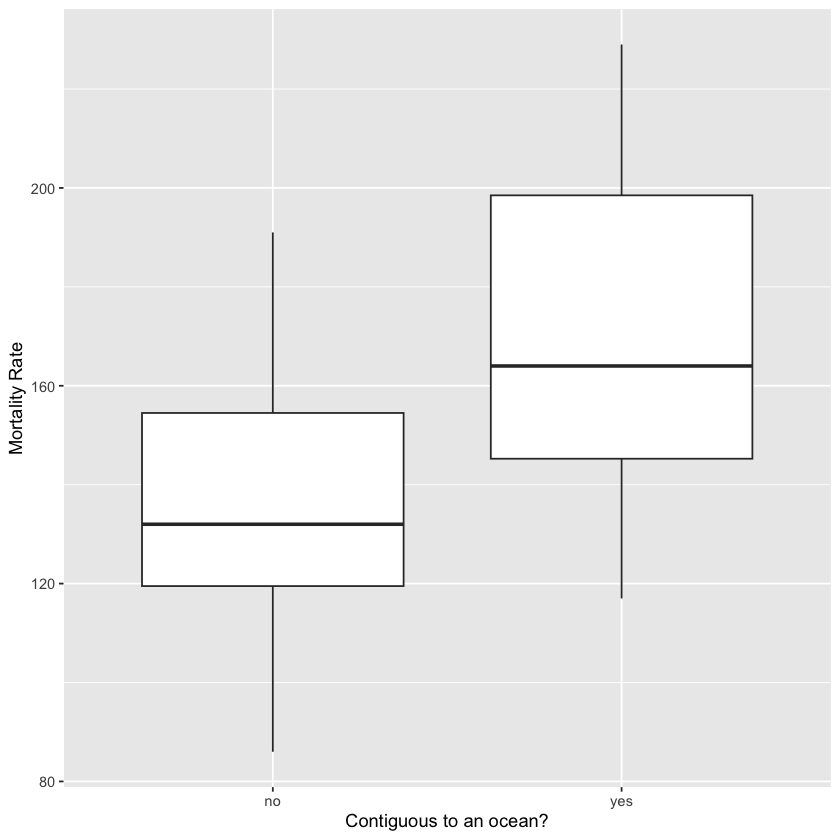

In [390]:
ggplot(data = USmelanoma, mapping = aes(x = ocean, y = mortality)) +
  geom_boxplot() +
  labs(x = "Contiguous to an ocean?", y = "Mortality Rate")

3. You might consider the Fisher & van Belle study data to be a random sample from two populations (of states), namely on the one hand from the homogeneous population of ocean states and on the other hand from the homogeneous population of non-ocean states. If you want to test if the location (e.g. the expected value) of the mortality rate is statistically significantly different between these two populations: what statistical significance test is appropriate, depending on the further assumptions you are willing to make with respect to the distribution of mortality rate within the respective population? Propose (at least) two approaches.

4. Do the statistical significance testing according to at least two proposed approaches and interpret the test results. Do you get different conclusions, depending on the chosen significance test?

### Welch t-test

$ t = \frac{mean_a - mean_b}{ \sqrt{ \frac{var_a}{n_a}  + \frac{var_b}{n_b} } } $ 
    
The p-value of a Welch t-test on this data set is ???.

In [391]:
yes_ocean = subset(USmelanoma, ocean == "yes")
no_ocean = subset(USmelanoma, ocean == "no")
t.test(yes_ocean$mortality, no_ocean$mortality)


	Welch Two Sample t-test

data:  yes_ocean$mortality and no_ocean$mortality
t = 3.5963, df = 39.539, p-value = 0.0008859
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 13.78495 49.18811
sample estimates:
mean of x mean of y 
 170.2273  138.7407 


### Mann Whitney U-test
The p-value for the U-test is ???.

In [392]:
wilcox.test(mortality ~ ocean, data=USmelanoma)

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  mortality by ocean
W = 134.5, p-value = 0.001125
alternative hypothesis: true location shift is not equal to 0
